In [1]:
from melee_dataset import MeleeDataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.distributions import Categorical
from torch.distributions import Bernoulli,Normal
import matplotlib.pyplot as plt
from PolicyNet import PolicyNet
import torch.nn.functional as F
from Agents.BCAgent import BCAgent

%load_ext autoreload
%autoreload 2

In [84]:
# train_dataset = MeleeDataset(data_path="data/train_mini_515")
# train_dataset = MeleeDataset(data_path="data/train_mini_40")
train_dataset = MeleeDataset(data_path="data/train_mini_5_fox_falco_dl")
# train_dataset = MeleeDataset(data_path="data/train_mini_10_with_hitstun")
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# val_dataset = MeleeDataset(data_path="data/val_mini_1")
# # val_dataset = MeleeDataset(data_path="data/val_mini_10")
# # val_dataset = MeleeDataset(data_path="data/val_mini_2_with_hitstun")
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)


In [3]:
print(f"obs_dim: {train_dataset[0][0].shape}")
print(f"act_dim: {train_dataset[0][1].shape}")

obs_dim: torch.Size([70])
act_dim: torch.Size([17])


In [85]:

from Agents.BCAgent import BCAgent
from Agents.IQLAgent import IQLAgent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
obs_dim = train_dataset[0][0].shape[0]
act_dim = train_dataset[0][1].shape[0]
agent = BCAgent(obs_dim, act_dim, device)
# agent = IQLAgent(obs_dim, act_dim, device, param_update_freq=50)

# set the seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

losses = []
val_losses = []
batch_cnt = 0
for epoch in range(20):
    total_loss = 0.0
    for i, (states, actions, next_states) in tqdm(enumerate(train_loader)):
        states = states.to(device)       # [B, obs_dim]
        actions = actions.to(device)     # [B] integers in [0…act_dim-1]
        next_states = next_states.to(device)
        # for i in range(1000):
        loss = agent.train(states, actions, next_states)
        # vl, ql, pl = loss
        # print(loss)
        losses.append(loss)
        # break
        total_loss += loss * states.shape[0]
        batch_cnt += 1

        # if batch_cnt % 100 == 0:
        #     val_loss = 0.0  
        #     for i, (states, actions, next_states) in tqdm(enumerate(val_loader)):
        #         states = states.to(device)       # [B, obs_dim]
        #         actions = actions.to(device)     # [B] integers in [0…act_dim-1]
        #         next_states = next_states.to(device)

        #         val_loss += agent.validate(states, actions)
        #     avg_val_loss = val_loss / len(val_dataset)
        #     val_losses.append(avg_val_loss)
        #     print(f"Epoch {epoch+1} — Val Loss: {avg_val_loss:.4f}")
    # break

    avg_loss = total_loss / len(train_dataset)
    # losses.append(avg_loss)
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}")




Using device: cuda


266it [00:04, 61.75it/s] 


Epoch 1 — Loss: -9.7948


266it [00:00, 315.55it/s]


Epoch 2 — Loss: -17.2919


266it [00:00, 316.16it/s]


Epoch 3 — Loss: -19.5790


266it [00:00, 314.76it/s]


Epoch 4 — Loss: -20.8353


266it [00:00, 344.76it/s]


Epoch 5 — Loss: -21.7249


266it [00:00, 317.32it/s]


Epoch 6 — Loss: -22.4156


266it [00:00, 321.82it/s]


Epoch 7 — Loss: -23.4640


266it [00:00, 332.57it/s]


Epoch 8 — Loss: -24.2388


266it [00:00, 321.46it/s]


Epoch 9 — Loss: -24.6706


266it [00:00, 311.14it/s]


Epoch 10 — Loss: -24.9299


266it [00:00, 325.04it/s]


Epoch 11 — Loss: -25.2646


266it [00:00, 344.02it/s]


Epoch 12 — Loss: -25.6137


266it [00:00, 329.55it/s]


Epoch 13 — Loss: -25.8819


266it [00:00, 334.96it/s]


Epoch 14 — Loss: -26.0117


266it [00:00, 357.31it/s]


Epoch 15 — Loss: -26.2480


266it [00:00, 373.85it/s]


Epoch 16 — Loss: -26.5473


266it [00:00, 347.52it/s]


Epoch 17 — Loss: -27.3366


266it [00:00, 344.74it/s]


Epoch 18 — Loss: -27.5804


266it [00:00, 359.73it/s]


Epoch 19 — Loss: -27.9125


266it [00:00, 319.75it/s]

Epoch 20 — Loss: -28.2543


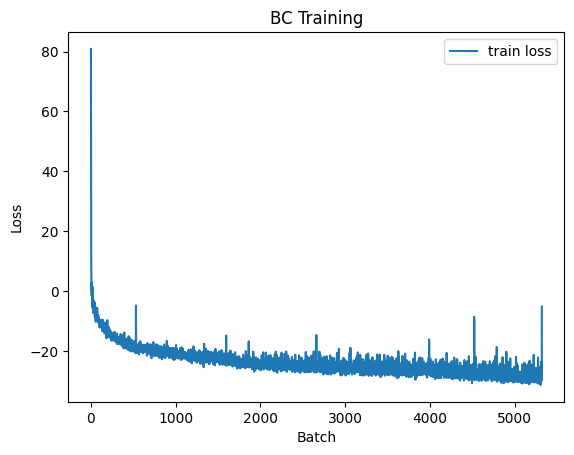

In [87]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.title("BC Training")
plt.xlabel("Batch")
plt.ylabel("Loss")
# plt.xticks(np.arange(0, 6, 1))
# plt.yscale("log")
# plt.plot([losses[i][0] for i in range(len(losses))], label="vl")
# plt.plot([losses[i][1] for i in range(len(losses))], label="ql")
# plt.plot([losses[i][2] for i in range(100,len(losses))], label="pl")
plt.plot(losses, label="train loss")
# plt.plot([100 * i for i in range(1, len(val_losses)+1)], val_losses, label="val loss")
plt.legend()
plt.show()



In [ ]:
# Save the trained model
# torch.save(agent.policy.state_dict(), "fox_5.pth")
torch.save(agent.policy_net.state_dict(), "fox_5.pth")
print("Model saved to trained_policy.pth")


AttributeError: 'BCAgent' object has no attribute 'policy'